In [20]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import itertools

%matplotlib inline

In [21]:
mnist = pd.read_csv("data/mnist1.5k.csv.gz", compression="gzip", header=None).values
X=mnist[:,1:785]/255.
y=mnist[:,0]
print ("dimension de las imagenes y las clases"), X.shape, y.shape

dimension de las imagenes y las clases


(None, (1500, 784), (1500,))

In [22]:
X_train, X_test, y_train, y_test = X[:300], X[300:], y[:300], y[300:]
y_train_oh = np.eye(10)[y_train]
y_test_oh  = np.eye(10)[y_test]
print( X_train.shape, y_train_oh.shape,  X_test.shape, y_test_oh.shape)

(300, 784) (300, 10) (1200, 784) (1200, 10)


## Network architectures lab


from the notes we have two architectures:
    
- **A**: Three layer network accepting a 784 element vector as input and outputing a 10-class vector
- **B**: Same as **A** but accepts an additional 2 element vector with _evenness_ information that is injected at the third layer.

This lab requires you to do two things:

**1**. Create a **C** architecture similar to **B** but where the 2 element vector is injected at the second layer. This will make the network have 41,650 parameters, distributed in the following way:
   
   

        INPUT 1 to LAYER 1:              784*50 + 50 (bias) = 39250
        LAYER 1 to LAYER 2:               50*30 + 30 (bias) = 1530
        LAYER 2 + INPUT 2 to LAYER 3: (30+2)*20 + 20 (bias) = 660
        LAYER 3 to OUTPUT:                20*10 + 10 (bias) = 210
    
                                                       TOTAL 41650
                                                       
**2**. Run an experimental setup where you train different network configurations and measure the accuracy on test data. Fix the number of neurons to 50, 30 and 20 for each layer and the following combination of parameters:

- For architecture **A** (3 configurations)

    `s3_activation` $\in$ `["linear", "relu", "tanh"]`

- For architectures **B** and **C** (15 configurations for each architecture)

    `s3_activation` $\in$ `["linear", "relu", "tanh"]`
    
    `k1,k2` $\in$ `[(0,1), (-.5,2),(-.5,30), (0,15),(0,30)]`

And create a heat map showing the accuracy in test obtained for each configuration, such as the following (your results should be approximate to this):

![alt text](./Images/mm_results_1.png)


And two bar plots with the average per architecture and k1,k2 configuration, such as the following (again, your results should be approximetely similar):

![alt text](./Images/mm_results_2.png)

### Model definitions

In [23]:
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, concatenate, Input
from tensorflow.keras.backend import clear_session

In [24]:
def get_model_A(input_dim, s1, s2, s3, s3_activation="relu"):
    clear_session()
    model = Sequential()
    model.add(Dense(s1, activation='relu', input_dim=input_dim))
    model.add(Dense(s2, activation='relu'))
    model.add(Dense(s3, activation=s3_activation))
    model.add(Dense(10, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy')
    model.reset_states()
    return model


In [25]:
def get_model_B(input_dim, extra_info_dim,  s1, s2, s3, s3_activation="relu"):
    clear_session()
    inp1 = Input(shape=(input_dim,))
    l11 = Dense(s1, activation="relu")(inp1)
    l12 = Dense(s2, activation="relu")(l11)
    l13 = Dense(s3, activation=s3_activation)(l12)
    inp2 = Input(shape=(extra_info_dim,))
    cc1 = concatenate([l13, inp2],axis=1) # Merge row, same column
    output = Dense(10, activation='softmax')(cc1)
    model = Model(inputs=[inp1, inp2], outputs=output)
    model.compile(optimizer='adam', loss='categorical_crossentropy')
    model.reset_states()
    return model

In [26]:
def get_model_C(input_dim, extra_info_dim,  s1, s2, s3, s3_activation="relu"):
    clear_session()
    inp1 = Input(shape=(input_dim,))
    l11 = Dense(s1, activation="relu")(inp1)
    l12 = Dense(s2, activation="relu")(l11)
    inp2 = Input(shape=(extra_info_dim,))
    cc1 = concatenate([l12, inp2],axis=1) # Merge row, same column
    l13 = Dense(s3, activation=s3_activation)(cc1)
    output = Dense(10, activation='softmax')(l13)
    model = Model(inputs=[inp1, inp2], outputs=output)
    model.compile(optimizer='adam', loss='categorical_crossentropy')
    model.reset_states()
    return model

In [27]:
def get_X_extra(y_train, y_test, k0, k1):
    X_train_extra = (np.eye(2)[y_train%2]+k0)*k1
    X_test_extra  = (np.eye(2)[y_test%2]+k0)*k1
    return X_train_extra, X_test_extra

### Use the following dataframe to record your data 

In [43]:
k_set     = [(0,1), (-.5,2),(-.5,30), (0,15),(0,30), None]
act_set   = ["linear", "relu", "tanh"]
arch_set  = ["A", "B", "C"]


r_test = pd.DataFrame(np.zeros((len(arch_set)*len(act_set), len(k_set)))*np.nan, 
                      index=[[a+"-"+b for a,b in itertools.product (arch_set, act_set)]],
                      columns=[str(i) for i in k_set])
r_test

,"(0, 1)","(-0.5, 2)","(-0.5, 30)","(0, 15)","(0, 30)",None
A-linear,NaN,NaN,NaN,NaN,NaN,NaN
A-relu,NaN,NaN,NaN,NaN,NaN,NaN
A-tanh,NaN,NaN,NaN,NaN,NaN,NaN
B-linear,NaN,NaN,NaN,NaN,NaN,NaN
B-relu,NaN,NaN,NaN,NaN,NaN,NaN
B-tanh,NaN,NaN,NaN,NaN,NaN,NaN
C-linear,NaN,NaN,NaN,NaN,NaN,NaN
C-relu,NaN,NaN,NaN,NaN,NaN,NaN
C-tanh,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
type(None)

NoneType

### Build a loop over the configurations

In [44]:
for k, act, arch in itertools.product(k_set, act_set, arch_set):
    
    if arch=="A"and k==None: 
        model = get_model_A(input_dim=X.shape[1], s1=50, s2=30, s3=20,s3_activation=act)
        model.fit(X_train, y_train_oh, epochs=200, batch_size=32, validation_data=(X_test, y_test_oh))
        preds_train = model.predict(X_train).argmax(axis=1)
        preds_test = model.predict(X_test).argmax(axis=1)
        acc=(np.mean(preds_test==y_test))
        r_test.loc[arch+'-'+act,str(k)]=acc
        acc=0
    
    if arch=="B"and k!=None:
        X_train_extra, X_test_extra = get_X_extra(y_train, y_test, k0=k[0], k1=k[1])    
        model = get_model_B(input_dim=X.shape[1], extra_info_dim=X_train_extra.shape[1], s1=50, s2=30, s3=20,s3_activation=act)
        model.fit([X_train, X_train_extra], y_train_oh, epochs=200, batch_size=32,validation_data=([X_test, X_test_extra], y_test_oh))
        preds_train = model.predict([X_train, X_train_extra]).argmax(axis=1)
        preds_test = model.predict([X_test, X_test_extra]).argmax(axis=1)
        acc=(np.mean(preds_test==y_test))
        r_test.loc[arch+'-'+act,str(k)]=acc
        acc=0
    
    if arch=="C"and k!=None:
        X_train_extra, X_test_extra = get_X_extra(y_train, y_test, k0=k[0], k1=k[1])    
        model = get_model_C(input_dim=X.shape[1], extra_info_dim=X_train_extra.shape[1], s1=50, s2=30, s3=20,s3_activation=act)
        model.fit([X_train, X_train_extra], y_train_oh, epochs=200, batch_size=32,validation_data=([X_test, X_test_extra], y_test_oh))
        preds_train = model.predict([X_train, X_train_extra]).argmax(axis=1)
        preds_test = model.predict([X_test, X_test_extra]).argmax(axis=1)
        acc=(np.mean(preds_test==y_test))
        r_test.loc[arch+'-'+act,str(k)]=acc
        acc=0
    #else:
     #   acc=0
      #  r_test.loc[arch+'-'+act,str(k)]=acc
        
    
        
    
    #print( "%10s %8s %1s"%(str(k), act, arch)    )
    
   


Train on 300 samples, validate on 1200 samples
Epoch 1/200
300/300 [==============================] - 0s 2ms/step - loss: 2.1628 - val_loss: 2.0286
Epoch 2/200
300/300 [==============================] - 0s 244us/step - loss: 1.8144 - val_loss: 1.7422
Epoch 3/200
300/300 [==============================] - 0s 255us/step - loss: 1.4334 - val_loss: 1.4213
Epoch 4/200
300/300 [==============================] - 0s 233us/step - loss: 1.0782 - val_loss: 1.1382
Epoch 5/200
300/300 [==============================] - 0s 230us/step - loss: 0.7991 - val_loss: 0.9647
Epoch 6/200
300/300 [==============================] - 0s 227us/step - loss: 0.6133 - val_loss: 0.7987
Epoch 7/200
300/300 [==============================] - 0s 223us/step - loss: 0.4673 - val_loss: 0.7720
Epoch 8/200
300/300 [==============================] - 0s 228us/step - loss: 0.3676 - val_loss: 0.6912
Epoch 9/200
300/300 [==============================] - 0s 223us/step - loss: 0.2952 - val_loss: 0.6616
Epoch 10/200
300/300 [======

Epoch 155/200
300/300 [==============================] - 0s 251us/step - loss: 3.1117e-04 - val_loss: 0.8985
Epoch 156/200
300/300 [==============================] - 0s 242us/step - loss: 3.0627e-04 - val_loss: 0.8991
Epoch 157/200
300/300 [==============================] - 0s 227us/step - loss: 3.0250e-04 - val_loss: 0.8983
Epoch 158/200
300/300 [==============================] - 0s 289us/step - loss: 2.9861e-04 - val_loss: 0.9004
Epoch 159/200
300/300 [==============================] - 0s 236us/step - loss: 2.9410e-04 - val_loss: 0.9032
Epoch 160/200
300/300 [==============================] - 0s 208us/step - loss: 2.8987e-04 - val_loss: 0.9046
Epoch 161/200
300/300 [==============================] - 0s 208us/step - loss: 2.8619e-04 - val_loss: 0.9050
Epoch 162/200
300/300 [==============================] - 0s 208us/step - loss: 2.8195e-04 - val_loss: 0.9051
Epoch 163/200
300/300 [==============================] - 0s 333us/step - loss: 2.7775e-04 - val_loss: 0.9065
Epoch 164/200
300/3

300/300 [==============================] - 0s 201us/step - loss: 7.1721e-04 - val_loss: 0.8279
Epoch 110/200
300/300 [==============================] - 0s 238us/step - loss: 7.0158e-04 - val_loss: 0.8301
Epoch 111/200
300/300 [==============================] - 0s 213us/step - loss: 6.8735e-04 - val_loss: 0.8310
Epoch 112/200
300/300 [==============================] - 0s 253us/step - loss: 6.7377e-04 - val_loss: 0.8317
Epoch 113/200
300/300 [==============================] - 0s 214us/step - loss: 6.6084e-04 - val_loss: 0.8336
Epoch 114/200
300/300 [==============================] - 0s 233us/step - loss: 6.5008e-04 - val_loss: 0.8360
Epoch 115/200
300/300 [==============================] - 0s 217us/step - loss: 6.3853e-04 - val_loss: 0.8376
Epoch 116/200
300/300 [==============================] - 0s 224us/step - loss: 6.2604e-04 - val_loss: 0.8381
Epoch 117/200
300/300 [==============================] - 0s 212us/step - loss: 6.1357e-04 - val_loss: 0.8386
Epoch 118/200
300/300 [==========

300/300 [==============================] - 0s 240us/step - loss: 0.0025 - val_loss: 0.8156
Epoch 62/200
300/300 [==============================] - 0s 253us/step - loss: 0.0024 - val_loss: 0.8190
Epoch 63/200
300/300 [==============================] - 0s 219us/step - loss: 0.0023 - val_loss: 0.8180
Epoch 64/200
300/300 [==============================] - 0s 225us/step - loss: 0.0022 - val_loss: 0.8224
Epoch 65/200
300/300 [==============================] - 0s 227us/step - loss: 0.0021 - val_loss: 0.8237
Epoch 66/200
300/300 [==============================] - 0s 240us/step - loss: 0.0020 - val_loss: 0.8266
Epoch 67/200
300/300 [==============================] - 0s 230us/step - loss: 0.0020 - val_loss: 0.8292
Epoch 68/200
300/300 [==============================] - 0s 205us/step - loss: 0.0019 - val_loss: 0.8310
Epoch 69/200
300/300 [==============================] - 0s 191us/step - loss: 0.0018 - val_loss: 0.8312
Epoch 70/200
300/300 [==============================] - 0s 224us/step - loss:

300/300 [==============================] - 0s 230us/step - loss: 0.5185 - val_loss: 0.8176
Epoch 13/200
300/300 [==============================] - 0s 217us/step - loss: 0.4187 - val_loss: 0.7540
Epoch 14/200
300/300 [==============================] - 0s 171us/step - loss: 0.3255 - val_loss: 0.6967
Epoch 15/200
300/300 [==============================] - 0s 215us/step - loss: 0.2529 - val_loss: 0.6534
Epoch 16/200
300/300 [==============================] - 0s 223us/step - loss: 0.2040 - val_loss: 0.6388
Epoch 17/200
300/300 [==============================] - 0s 181us/step - loss: 0.1673 - val_loss: 0.6166
Epoch 18/200
300/300 [==============================] - 0s 218us/step - loss: 0.1374 - val_loss: 0.6214
Epoch 19/200
300/300 [==============================] - 0s 173us/step - loss: 0.1193 - val_loss: 0.6124
Epoch 20/200
300/300 [==============================] - 0s 216us/step - loss: 0.0988 - val_loss: 0.6017
Epoch 21/200
300/300 [==============================] - 0s 176us/step - loss:

Epoch 91/200
300/300 [==============================] - 0s 225us/step - loss: 0.0012 - val_loss: 0.8446
Epoch 92/200
300/300 [==============================] - 0s 187us/step - loss: 0.0012 - val_loss: 0.8484
Epoch 93/200
300/300 [==============================] - 0s 255us/step - loss: 0.0012 - val_loss: 0.8502
Epoch 94/200
300/300 [==============================] - 0s 190us/step - loss: 0.0012 - val_loss: 0.8508
Epoch 95/200
300/300 [==============================] - 0s 217us/step - loss: 0.0011 - val_loss: 0.8549
Epoch 96/200
300/300 [==============================] - 0s 271us/step - loss: 0.0011 - val_loss: 0.8606
Epoch 97/200
300/300 [==============================] - 0s 220us/step - loss: 0.0011 - val_loss: 0.8616
Epoch 98/200
300/300 [==============================] - 0s 223us/step - loss: 0.0010 - val_loss: 0.8615
Epoch 99/200
300/300 [==============================] - 0s 225us/step - loss: 0.0010 - val_loss: 0.8597
Epoch 100/200
300/300 [==============================] - 0s 218u

Epoch 43/200
300/300 [==============================] - 0s 220us/step - loss: 0.0401 - val_loss: 0.6686
Epoch 44/200
300/300 [==============================] - 0s 221us/step - loss: 0.0383 - val_loss: 0.6673
Epoch 45/200
300/300 [==============================] - 0s 228us/step - loss: 0.0367 - val_loss: 0.6683
Epoch 46/200
300/300 [==============================] - 0s 201us/step - loss: 0.0351 - val_loss: 0.6705
Epoch 47/200
300/300 [==============================] - 0s 229us/step - loss: 0.0337 - val_loss: 0.6673
Epoch 48/200
300/300 [==============================] - 0s 214us/step - loss: 0.0324 - val_loss: 0.6673
Epoch 49/200
300/300 [==============================] - 0s 235us/step - loss: 0.0311 - val_loss: 0.6706
Epoch 50/200
300/300 [==============================] - 0s 214us/step - loss: 0.0299 - val_loss: 0.6708
Epoch 51/200
300/300 [==============================] - 0s 222us/step - loss: 0.0289 - val_loss: 0.6703
Epoch 52/200
300/300 [==============================] - 0s 229us

300/300 [==============================] - 0s 208us/step - loss: 0.0025 - val_loss: 0.8034
Epoch 200/200
300/300 [==============================] - 0s 208us/step - loss: 0.0025 - val_loss: 0.8048
Train on 300 samples, validate on 1200 samples
Epoch 1/200
300/300 [==============================] - 0s 1ms/step - loss: 2.1364 - val_loss: 2.0096
Epoch 2/200
300/300 [==============================] - 0s 208us/step - loss: 1.8412 - val_loss: 1.7643
Epoch 3/200
300/300 [==============================] - 0s 208us/step - loss: 1.5436 - val_loss: 1.5192
Epoch 4/200
300/300 [==============================] - 0s 208us/step - loss: 1.2892 - val_loss: 1.3478
Epoch 5/200
300/300 [==============================] - 0s 156us/step - loss: 1.0807 - val_loss: 1.1850
Epoch 6/200
300/300 [==============================] - 0s 208us/step - loss: 0.9189 - val_loss: 1.0903
Epoch 7/200
300/300 [==============================] - 0s 208us/step - loss: 0.7877 - val_loss: 0.9935
Epoch 8/200
300/300 [=================

300/300 [==============================] - 0s 208us/step - loss: 0.0037 - val_loss: 0.7769
Epoch 156/200
300/300 [==============================] - 0s 208us/step - loss: 0.0036 - val_loss: 0.7777
Epoch 157/200
300/300 [==============================] - 0s 208us/step - loss: 0.0036 - val_loss: 0.7798
Epoch 158/200
300/300 [==============================] - 0s 208us/step - loss: 0.0035 - val_loss: 0.7788
Epoch 159/200
300/300 [==============================] - 0s 156us/step - loss: 0.0035 - val_loss: 0.7785
Epoch 160/200
300/300 [==============================] - 0s 156us/step - loss: 0.0034 - val_loss: 0.7796
Epoch 161/200
300/300 [==============================] - 0s 208us/step - loss: 0.0034 - val_loss: 0.7827
Epoch 162/200
300/300 [==============================] - 0s 208us/step - loss: 0.0034 - val_loss: 0.7835
Epoch 163/200
300/300 [==============================] - 0s 208us/step - loss: 0.0033 - val_loss: 0.7833
Epoch 164/200
300/300 [==============================] - 0s 210us/ste

300/300 [==============================] - 0s 260us/step - loss: 0.0131 - val_loss: 0.6522
Epoch 34/200
300/300 [==============================] - 0s 260us/step - loss: 0.0121 - val_loss: 0.6535
Epoch 35/200
300/300 [==============================] - 0s 208us/step - loss: 0.0112 - val_loss: 0.6606
Epoch 36/200
300/300 [==============================] - 0s 260us/step - loss: 0.0104 - val_loss: 0.6621
Epoch 37/200
300/300 [==============================] - 0s 260us/step - loss: 0.0097 - val_loss: 0.6674
Epoch 38/200
300/300 [==============================] - 0s 260us/step - loss: 0.0091 - val_loss: 0.6648
Epoch 39/200
300/300 [==============================] - 0s 208us/step - loss: 0.0087 - val_loss: 0.6658
Epoch 40/200
300/300 [==============================] - 0s 260us/step - loss: 0.0081 - val_loss: 0.6732
Epoch 41/200
300/300 [==============================] - 0s 208us/step - loss: 0.0076 - val_loss: 0.6745
Epoch 42/200
300/300 [==============================] - 0s 208us/step - loss:

300/300 [==============================] - 0s 208us/step - loss: 2.5177e-04 - val_loss: 0.8897
Epoch 187/200
300/300 [==============================] - 0s 156us/step - loss: 2.4878e-04 - val_loss: 0.8900
Epoch 188/200
300/300 [==============================] - 0s 208us/step - loss: 2.4590e-04 - val_loss: 0.8910
Epoch 189/200
300/300 [==============================] - 0s 208us/step - loss: 2.4272e-04 - val_loss: 0.8917
Epoch 190/200
300/300 [==============================] - 0s 208us/step - loss: 2.3959e-04 - val_loss: 0.8927
Epoch 191/200
300/300 [==============================] - 0s 208us/step - loss: 2.3675e-04 - val_loss: 0.8941
Epoch 192/200
300/300 [==============================] - 0s 213us/step - loss: 2.3386e-04 - val_loss: 0.8952
Epoch 193/200
300/300 [==============================] - 0s 198us/step - loss: 2.3105e-04 - val_loss: 0.8961
Epoch 194/200
300/300 [==============================] - 0s 208us/step - loss: 2.2829e-04 - val_loss: 0.8969
Epoch 195/200
300/300 [==========

300/300 [==============================] - 0s 156us/step - loss: 4.2215e-04 - val_loss: 0.7970
Epoch 140/200
300/300 [==============================] - 0s 208us/step - loss: 4.1511e-04 - val_loss: 0.7987
Epoch 141/200
300/300 [==============================] - 0s 208us/step - loss: 4.0916e-04 - val_loss: 0.7994
Epoch 142/200
300/300 [==============================] - 0s 208us/step - loss: 4.0250e-04 - val_loss: 0.8000
Epoch 143/200
300/300 [==============================] - 0s 156us/step - loss: 3.9711e-04 - val_loss: 0.8027
Epoch 144/200
300/300 [==============================] - 0s 156us/step - loss: 3.9069e-04 - val_loss: 0.8042
Epoch 145/200
300/300 [==============================] - 0s 208us/step - loss: 3.8395e-04 - val_loss: 0.8057
Epoch 146/200
300/300 [==============================] - 0s 208us/step - loss: 3.7851e-04 - val_loss: 0.8066
Epoch 147/200
300/300 [==============================] - 0s 156us/step - loss: 3.7298e-04 - val_loss: 0.8076
Epoch 148/200
300/300 [==========

Epoch 93/200
300/300 [==============================] - 0s 208us/step - loss: 0.0011 - val_loss: 0.8692
Epoch 94/200
300/300 [==============================] - 0s 208us/step - loss: 0.0011 - val_loss: 0.8719
Epoch 95/200
300/300 [==============================] - 0s 208us/step - loss: 0.0011 - val_loss: 0.8721
Epoch 96/200
300/300 [==============================] - 0s 208us/step - loss: 0.0011 - val_loss: 0.8791
Epoch 97/200
300/300 [==============================] - 0s 208us/step - loss: 0.0010 - val_loss: 0.8803
Epoch 98/200
300/300 [==============================] - 0s 156us/step - loss: 0.0010 - val_loss: 0.8802
Epoch 99/200
300/300 [==============================] - 0s 229us/step - loss: 9.8711e-04 - val_loss: 0.8816
Epoch 100/200
300/300 [==============================] - 0s 208us/step - loss: 9.6779e-04 - val_loss: 0.8809
Epoch 101/200
300/300 [==============================] - 0s 208us/step - loss: 9.4298e-04 - val_loss: 0.8839
Epoch 102/200
300/300 [===========================

300/300 [==============================] - 0s 208us/step - loss: 0.0093 - val_loss: 0.6161
Epoch 45/200
300/300 [==============================] - 0s 208us/step - loss: 0.0088 - val_loss: 0.6152
Epoch 46/200
300/300 [==============================] - 0s 208us/step - loss: 0.0083 - val_loss: 0.6233
Epoch 47/200
300/300 [==============================] - 0s 156us/step - loss: 0.0078 - val_loss: 0.6311
Epoch 48/200
300/300 [==============================] - 0s 208us/step - loss: 0.0074 - val_loss: 0.6301
Epoch 49/200
300/300 [==============================] - 0s 208us/step - loss: 0.0070 - val_loss: 0.6333
Epoch 50/200
300/300 [==============================] - 0s 208us/step - loss: 0.0067 - val_loss: 0.6355
Epoch 51/200
300/300 [==============================] - 0s 156us/step - loss: 0.0063 - val_loss: 0.6430
Epoch 52/200
300/300 [==============================] - 0s 208us/step - loss: 0.0061 - val_loss: 0.6430
Epoch 53/200
300/300 [==============================] - 0s 208us/step - loss:

300/300 [==============================] - 0s 208us/step - loss: 2.7350e-04 - val_loss: 0.8773
Epoch 197/200
300/300 [==============================] - 0s 208us/step - loss: 2.7005e-04 - val_loss: 0.8771
Epoch 198/200
300/300 [==============================] - 0s 156us/step - loss: 2.6662e-04 - val_loss: 0.8786
Epoch 199/200
300/300 [==============================] - 0s 208us/step - loss: 2.6330e-04 - val_loss: 0.8779
Epoch 200/200
300/300 [==============================] - 0s 208us/step - loss: 2.6076e-04 - val_loss: 0.8788
Train on 300 samples, validate on 1200 samples
Epoch 1/200
300/300 [==============================] - 0s 1ms/step - loss: 2.3515 - val_loss: 2.2396
Epoch 2/200
300/300 [==============================] - 0s 208us/step - loss: 2.0655 - val_loss: 2.0301
Epoch 3/200
300/300 [==============================] - 0s 208us/step - loss: 1.8019 - val_loss: 1.8160
Epoch 4/200
300/300 [==============================] - 0s 156us/step - loss: 1.5509 - val_loss: 1.6345
Epoch 5/200


300/300 [==============================] - 0s 156us/step - loss: 0.0034 - val_loss: 0.8913
Epoch 153/200
300/300 [==============================] - 0s 208us/step - loss: 0.0033 - val_loss: 0.8921
Epoch 154/200
300/300 [==============================] - 0s 156us/step - loss: 0.0033 - val_loss: 0.8935
Epoch 155/200
300/300 [==============================] - 0s 208us/step - loss: 0.0033 - val_loss: 0.8944
Epoch 156/200
300/300 [==============================] - 0s 208us/step - loss: 0.0032 - val_loss: 0.8958
Epoch 157/200
300/300 [==============================] - 0s 208us/step - loss: 0.0032 - val_loss: 0.8959
Epoch 158/200
300/300 [==============================] - 0s 208us/step - loss: 0.0032 - val_loss: 0.8967
Epoch 159/200
300/300 [==============================] - ETA: 0s - loss: 0.002 - 0s 156us/step - loss: 0.0031 - val_loss: 0.8977
Epoch 160/200
300/300 [==============================] - 0s 156us/step - loss: 0.0031 - val_loss: 0.8986
Epoch 161/200
300/300 [======================

Epoch 108/200
300/300 [==============================] - 0s 208us/step - loss: 0.0077 - val_loss: 0.6913
Epoch 109/200
300/300 [==============================] - 0s 208us/step - loss: 0.0075 - val_loss: 0.6929
Epoch 110/200
300/300 [==============================] - 0s 208us/step - loss: 0.0074 - val_loss: 0.6959
Epoch 111/200
300/300 [==============================] - 0s 187us/step - loss: 0.0073 - val_loss: 0.6992
Epoch 112/200
300/300 [==============================] - 0s 225us/step - loss: 0.0072 - val_loss: 0.6993
Epoch 113/200
300/300 [==============================] - 0s 208us/step - loss: 0.0071 - val_loss: 0.6964
Epoch 114/200
300/300 [==============================] - 0s 156us/step - loss: 0.0070 - val_loss: 0.6978
Epoch 115/200
300/300 [==============================] - 0s 196us/step - loss: 0.0069 - val_loss: 0.7000
Epoch 116/200
300/300 [==============================] - 0s 156us/step - loss: 0.0068 - val_loss: 0.7004
Epoch 117/200
300/300 [==============================] 

300/300 [==============================] - 0s 156us/step - loss: 0.0029 - val_loss: 0.7530
Epoch 187/200
300/300 [==============================] - 0s 156us/step - loss: 0.0029 - val_loss: 0.7547
Epoch 188/200
300/300 [==============================] - 0s 208us/step - loss: 0.0028 - val_loss: 0.7551
Epoch 189/200
300/300 [==============================] - 0s 208us/step - loss: 0.0028 - val_loss: 0.7555
Epoch 190/200
300/300 [==============================] - 0s 208us/step - loss: 0.0028 - val_loss: 0.7564
Epoch 191/200
300/300 [==============================] - 0s 156us/step - loss: 0.0028 - val_loss: 0.7573
Epoch 192/200
300/300 [==============================] - 0s 246us/step - loss: 0.0027 - val_loss: 0.7573
Epoch 193/200
300/300 [==============================] - 0s 208us/step - loss: 0.0027 - val_loss: 0.7578
Epoch 194/200
300/300 [==============================] - 0s 213us/step - loss: 0.0027 - val_loss: 0.7579
Epoch 195/200
300/300 [==============================] - 0s 196us/ste

Epoch 64/200
300/300 [==============================] - 0s 156us/step - loss: 1.2390 - val_loss: 2.2622
Epoch 65/200
300/300 [==============================] - 0s 208us/step - loss: 1.2389 - val_loss: 2.2643
Epoch 66/200
300/300 [==============================] - 0s 208us/step - loss: 1.2388 - val_loss: 2.2626
Epoch 67/200
300/300 [==============================] - 0s 156us/step - loss: 1.2387 - val_loss: 2.2621
Epoch 68/200
300/300 [==============================] - 0s 156us/step - loss: 1.2386 - val_loss: 2.2622
Epoch 69/200
300/300 [==============================] - 0s 208us/step - loss: 1.2385 - val_loss: 2.2635
Epoch 70/200
300/300 [==============================] - 0s 156us/step - loss: 1.2384 - val_loss: 2.2640
Epoch 71/200
300/300 [==============================] - 0s 208us/step - loss: 1.2383 - val_loss: 2.2659
Epoch 72/200
300/300 [==============================] - 0s 208us/step - loss: 1.2383 - val_loss: 2.2676
Epoch 73/200
300/300 [==============================] - 0s 141us

Epoch 20/200
300/300 [==============================] - 0s 208us/step - loss: 0.0589 - val_loss: 0.4242
Epoch 21/200
300/300 [==============================] - 0s 208us/step - loss: 0.0506 - val_loss: 0.4156
Epoch 22/200
300/300 [==============================] - 0s 208us/step - loss: 0.0438 - val_loss: 0.4152
Epoch 23/200
300/300 [==============================] - 0s 208us/step - loss: 0.0382 - val_loss: 0.4106
Epoch 24/200
300/300 [==============================] - 0s 208us/step - loss: 0.0334 - val_loss: 0.4135
Epoch 25/200
300/300 [==============================] - 0s 260us/step - loss: 0.0294 - val_loss: 0.4164
Epoch 26/200
300/300 [==============================] - 0s 156us/step - loss: 0.0262 - val_loss: 0.4069
Epoch 27/200
300/300 [==============================] - 0s 208us/step - loss: 0.0235 - val_loss: 0.4103
Epoch 28/200
300/300 [==============================] - 0s 208us/step - loss: 0.0211 - val_loss: 0.4113
Epoch 29/200
300/300 [==============================] - 0s 208us

300/300 [==============================] - 0s 156us/step - loss: 2.8010e-04 - val_loss: 0.5018
Epoch 174/200
300/300 [==============================] - 0s 208us/step - loss: 2.7637e-04 - val_loss: 0.5026
Epoch 175/200
300/300 [==============================] - 0s 208us/step - loss: 2.7272e-04 - val_loss: 0.5030
Epoch 176/200
300/300 [==============================] - 0s 208us/step - loss: 2.6931e-04 - val_loss: 0.5034
Epoch 177/200
300/300 [==============================] - 0s 156us/step - loss: 2.6580e-04 - val_loss: 0.5041
Epoch 178/200
300/300 [==============================] - 0s 179us/step - loss: 2.6209e-04 - val_loss: 0.5046
Epoch 179/200
300/300 [==============================] - 0s 156us/step - loss: 2.5867e-04 - val_loss: 0.5042
Epoch 180/200
300/300 [==============================] - 0s 208us/step - loss: 2.5543e-04 - val_loss: 0.5043
Epoch 181/200
300/300 [==============================] - 0s 208us/step - loss: 2.5195e-04 - val_loss: 0.5054
Epoch 182/200
300/300 [==========

300/300 [==============================] - 0s 156us/step - loss: 7.1541e-04 - val_loss: 0.9211
Epoch 128/200
300/300 [==============================] - 0s 208us/step - loss: 7.0267e-04 - val_loss: 0.9220
Epoch 129/200
300/300 [==============================] - 0s 208us/step - loss: 6.8907e-04 - val_loss: 0.9222
Epoch 130/200
300/300 [==============================] - 0s 156us/step - loss: 6.7849e-04 - val_loss: 0.9228
Epoch 131/200
300/300 [==============================] - 0s 159us/step - loss: 6.6704e-04 - val_loss: 0.9248
Epoch 132/200
300/300 [==============================] - 0s 208us/step - loss: 6.5565e-04 - val_loss: 0.9259
Epoch 133/200
300/300 [==============================] - 0s 208us/step - loss: 6.4587e-04 - val_loss: 0.9243
Epoch 134/200
300/300 [==============================] - 0s 156us/step - loss: 6.3554e-04 - val_loss: 0.9249
Epoch 135/200
300/300 [==============================] - 0s 184us/step - loss: 6.2419e-04 - val_loss: 0.9249
Epoch 136/200
300/300 [==========

Epoch 80/200
300/300 [==============================] - 0s 208us/step - loss: 0.0015 - val_loss: 0.4613
Epoch 81/200
300/300 [==============================] - 0s 208us/step - loss: 0.0015 - val_loss: 0.4616
Epoch 82/200
300/300 [==============================] - 0s 156us/step - loss: 0.0014 - val_loss: 0.4623
Epoch 83/200
300/300 [==============================] - 0s 208us/step - loss: 0.0014 - val_loss: 0.4621
Epoch 84/200
300/300 [==============================] - 0s 208us/step - loss: 0.0013 - val_loss: 0.4649
Epoch 85/200
300/300 [==============================] - 0s 208us/step - loss: 0.0013 - val_loss: 0.4662
Epoch 86/200
300/300 [==============================] - 0s 208us/step - loss: 0.0013 - val_loss: 0.4676
Epoch 87/200
300/300 [==============================] - 0s 208us/step - loss: 0.0012 - val_loss: 0.4684
Epoch 88/200
300/300 [==============================] - 0s 208us/step - loss: 0.0012 - val_loss: 0.4679
Epoch 89/200
300/300 [==============================] - 0s 208us

Epoch 156/200
300/300 [==============================] - 0s 260us/step - loss: 3.2014e-04 - val_loss: 0.5120
Epoch 157/200
300/300 [==============================] - 0s 208us/step - loss: 3.1575e-04 - val_loss: 0.5125
Epoch 158/200
300/300 [==============================] - 0s 285us/step - loss: 3.1132e-04 - val_loss: 0.5131
Epoch 159/200
300/300 [==============================] - 0s 260us/step - loss: 3.0623e-04 - val_loss: 0.5129
Epoch 160/200
300/300 [==============================] - 0s 156us/step - loss: 3.0202e-04 - val_loss: 0.5132
Epoch 161/200
300/300 [==============================] - 0s 208us/step - loss: 2.9795e-04 - val_loss: 0.5139
Epoch 162/200
300/300 [==============================] - 0s 208us/step - loss: 2.9309e-04 - val_loss: 0.5144
Epoch 163/200
300/300 [==============================] - 0s 208us/step - loss: 2.8847e-04 - val_loss: 0.5149
Epoch 164/200
300/300 [==============================] - 0s 156us/step - loss: 2.8434e-04 - val_loss: 0.5151
Epoch 165/200
300/3

300/300 [==============================] - 0s 208us/step - loss: 0.0211 - val_loss: 0.5708
Epoch 111/200
300/300 [==============================] - 0s 208us/step - loss: 0.0208 - val_loss: 0.5699
Epoch 112/200
300/300 [==============================] - 0s 208us/step - loss: 0.0205 - val_loss: 0.5695
Epoch 113/200
300/300 [==============================] - 0s 208us/step - loss: 0.0201 - val_loss: 0.5700
Epoch 114/200
300/300 [==============================] - 0s 156us/step - loss: 0.0197 - val_loss: 0.5703
Epoch 115/200
300/300 [==============================] - 0s 208us/step - loss: 0.0194 - val_loss: 0.5700
Epoch 116/200
300/300 [==============================] - 0s 208us/step - loss: 0.0191 - val_loss: 0.5707
Epoch 117/200
300/300 [==============================] - 0s 208us/step - loss: 0.0187 - val_loss: 0.5704
Epoch 118/200
300/300 [==============================] - 0s 208us/step - loss: 0.0184 - val_loss: 0.5706
Epoch 119/200
300/300 [==============================] - 0s 208us/ste

300/300 [==============================] - 0s 156us/step - loss: 0.0319 - val_loss: 0.4183
Epoch 67/200
300/300 [==============================] - 0s 156us/step - loss: 0.0312 - val_loss: 0.4178
Epoch 68/200
300/300 [==============================] - 0s 156us/step - loss: 0.0304 - val_loss: 0.4170
Epoch 69/200
300/300 [==============================] - 0s 208us/step - loss: 0.0298 - val_loss: 0.4173
Epoch 70/200
300/300 [==============================] - 0s 208us/step - loss: 0.0291 - val_loss: 0.4192
Epoch 71/200
300/300 [==============================] - 0s 208us/step - loss: 0.0284 - val_loss: 0.4202
Epoch 72/200
300/300 [==============================] - 0s 208us/step - loss: 0.0278 - val_loss: 0.4190
Epoch 73/200
300/300 [==============================] - 0s 208us/step - loss: 0.0272 - val_loss: 0.4193
Epoch 74/200
300/300 [==============================] - 0s 156us/step - loss: 0.0266 - val_loss: 0.4194
Epoch 75/200
300/300 [==============================] - 0s 156us/step - loss:

300/300 [==============================] - 0s 208us/step - loss: 0.0085 - val_loss: 0.4582
Epoch 145/200
300/300 [==============================] - 0s 208us/step - loss: 0.0083 - val_loss: 0.4580
Epoch 146/200
300/300 [==============================] - 0s 208us/step - loss: 0.0082 - val_loss: 0.4588
Epoch 147/200
300/300 [==============================] - 0s 208us/step - loss: 0.0081 - val_loss: 0.4592
Epoch 148/200
300/300 [==============================] - 0s 182us/step - loss: 0.0080 - val_loss: 0.4594
Epoch 149/200
300/300 [==============================] - 0s 208us/step - loss: 0.0079 - val_loss: 0.4597
Epoch 150/200
300/300 [==============================] - 0s 208us/step - loss: 0.0078 - val_loss: 0.4600
Epoch 151/200
300/300 [==============================] - 0s 156us/step - loss: 0.0078 - val_loss: 0.4609
Epoch 152/200
300/300 [==============================] - 0s 156us/step - loss: 0.0077 - val_loss: 0.4603
Epoch 153/200
300/300 [==============================] - 0s 208us/ste

300/300 [==============================] - 0s 195us/step - loss: 0.0412 - val_loss: 0.4548
Epoch 23/200
300/300 [==============================] - 0s 260us/step - loss: 0.0365 - val_loss: 0.4553
Epoch 24/200
300/300 [==============================] - 0s 260us/step - loss: 0.0319 - val_loss: 0.4597
Epoch 25/200
300/300 [==============================] - 0s 208us/step - loss: 0.0287 - val_loss: 0.4551
Epoch 26/200
300/300 [==============================] - 0s 208us/step - loss: 0.0253 - val_loss: 0.4522
Epoch 27/200
300/300 [==============================] - 0s 208us/step - loss: 0.0232 - val_loss: 0.4570
Epoch 28/200
300/300 [==============================] - 0s 156us/step - loss: 0.0209 - val_loss: 0.4529
Epoch 29/200
300/300 [==============================] - 0s 208us/step - loss: 0.0190 - val_loss: 0.4532
Epoch 30/200
300/300 [==============================] - 0s 208us/step - loss: 0.0174 - val_loss: 0.4566
Epoch 31/200
300/300 [==============================] - 0s 208us/step - loss:

300/300 [==============================] - 0s 156us/step - loss: 3.2223e-04 - val_loss: 0.5717
Epoch 176/200
300/300 [==============================] - 0s 208us/step - loss: 3.1805e-04 - val_loss: 0.5719
Epoch 177/200
300/300 [==============================] - 0s 208us/step - loss: 3.1397e-04 - val_loss: 0.5729
Epoch 178/200
300/300 [==============================] - 0s 156us/step - loss: 3.1019e-04 - val_loss: 0.5733
Epoch 179/200
300/300 [==============================] - 0s 208us/step - loss: 3.0596e-04 - val_loss: 0.5735
Epoch 180/200
300/300 [==============================] - 0s 208us/step - loss: 3.0173e-04 - val_loss: 0.5738
Epoch 181/200
300/300 [==============================] - 0s 156us/step - loss: 2.9812e-04 - val_loss: 0.5747
Epoch 182/200
300/300 [==============================] - 0s 156us/step - loss: 2.9468e-04 - val_loss: 0.5757
Epoch 183/200
300/300 [==============================] - 0s 208us/step - loss: 2.9043e-04 - val_loss: 0.5757
Epoch 184/200
300/300 [==========

Epoch 130/200
300/300 [==============================] - 0s 208us/step - loss: 6.5529e-04 - val_loss: 0.5700
Epoch 131/200
300/300 [==============================] - 0s 156us/step - loss: 6.4413e-04 - val_loss: 0.5699
Epoch 132/200
300/300 [==============================] - 0s 208us/step - loss: 6.3159e-04 - val_loss: 0.5725
Epoch 133/200
300/300 [==============================] - 0s 208us/step - loss: 6.2058e-04 - val_loss: 0.5731
Epoch 134/200
300/300 [==============================] - 0s 208us/step - loss: 6.1161e-04 - val_loss: 0.5760
Epoch 135/200
300/300 [==============================] - 0s 208us/step - loss: 6.0166e-04 - val_loss: 0.5748
Epoch 136/200
300/300 [==============================] - 0s 208us/step - loss: 5.9052e-04 - val_loss: 0.5748
Epoch 137/200
300/300 [==============================] - 0s 186us/step - loss: 5.7853e-04 - val_loss: 0.5771
Epoch 138/200
300/300 [==============================] - 0s 156us/step - loss: 5.6928e-04 - val_loss: 0.5784
Epoch 139/200
300/3

Epoch 5/200
300/300 [==============================] - 0s 208us/step - loss: 1.9349 - val_loss: 2.0705
Epoch 6/200
300/300 [==============================] - 0s 208us/step - loss: 1.6543 - val_loss: 1.8196
Epoch 7/200
300/300 [==============================] - 0s 208us/step - loss: 1.3857 - val_loss: 1.5840
Epoch 8/200
300/300 [==============================] - 0s 156us/step - loss: 1.1543 - val_loss: 1.4144
Epoch 9/200
300/300 [==============================] - 0s 156us/step - loss: 0.9566 - val_loss: 1.2331
Epoch 10/200
300/300 [==============================] - 0s 208us/step - loss: 0.7858 - val_loss: 1.1409
Epoch 11/200
300/300 [==============================] - 0s 208us/step - loss: 0.6389 - val_loss: 1.0135
Epoch 12/200
300/300 [==============================] - 0s 208us/step - loss: 0.5242 - val_loss: 0.9911
Epoch 13/200
300/300 [==============================] - 0s 208us/step - loss: 0.4479 - val_loss: 0.8861
Epoch 14/200
300/300 [==============================] - 0s 208us/step

Epoch 159/200
300/300 [==============================] - 0s 208us/step - loss: 3.5108e-04 - val_loss: 1.0173
Epoch 160/200
300/300 [==============================] - 0s 156us/step - loss: 3.4636e-04 - val_loss: 1.0175
Epoch 161/200
300/300 [==============================] - 0s 208us/step - loss: 3.4026e-04 - val_loss: 1.0172
Epoch 162/200
300/300 [==============================] - 0s 208us/step - loss: 3.3546e-04 - val_loss: 1.0194
Epoch 163/200
300/300 [==============================] - 0s 199us/step - loss: 3.2969e-04 - val_loss: 1.0192
Epoch 164/200
300/300 [==============================] - 0s 208us/step - loss: 3.2496e-04 - val_loss: 1.0192
Epoch 165/200
300/300 [==============================] - 0s 156us/step - loss: 3.2029e-04 - val_loss: 1.0229
Epoch 166/200
300/300 [==============================] - 0s 156us/step - loss: 3.1525e-04 - val_loss: 1.0247
Epoch 167/200
300/300 [==============================] - 0s 208us/step - loss: 3.1056e-04 - val_loss: 1.0256
Epoch 168/200
300/3

300/300 [==============================] - 0s 156us/step - loss: 9.5366e-04 - val_loss: 0.5504
Epoch 114/200
300/300 [==============================] - 0s 208us/step - loss: 9.3308e-04 - val_loss: 0.5514
Epoch 115/200
300/300 [==============================] - 0s 156us/step - loss: 9.1299e-04 - val_loss: 0.5524
Epoch 116/200
300/300 [==============================] - 0s 156us/step - loss: 8.9435e-04 - val_loss: 0.5539
Epoch 117/200
300/300 [==============================] - 0s 234us/step - loss: 8.7610e-04 - val_loss: 0.5556
Epoch 118/200
300/300 [==============================] - 0s 187us/step - loss: 8.5954e-04 - val_loss: 0.5558
Epoch 119/200
300/300 [==============================] - 0s 174us/step - loss: 8.4503e-04 - val_loss: 0.5563
Epoch 120/200
300/300 [==============================] - 0s 208us/step - loss: 8.2331e-04 - val_loss: 0.5581
Epoch 121/200
300/300 [==============================] - 0s 156us/step - loss: 8.0826e-04 - val_loss: 0.5592
Epoch 122/200
300/300 [==========

300/300 [==============================] - 0s 208us/step - loss: 0.0203 - val_loss: 0.4955
Epoch 66/200
300/300 [==============================] - 0s 208us/step - loss: 0.0198 - val_loss: 0.4957
Epoch 67/200
300/300 [==============================] - 0s 313us/step - loss: 0.0192 - val_loss: 0.4960
Epoch 68/200
300/300 [==============================] - 0s 313us/step - loss: 0.0186 - val_loss: 0.4951
Epoch 69/200
300/300 [==============================] - 0s 313us/step - loss: 0.0181 - val_loss: 0.4961
Epoch 70/200
300/300 [==============================] - 0s 313us/step - loss: 0.0175 - val_loss: 0.4980
Epoch 71/200
300/300 [==============================] - 0s 260us/step - loss: 0.0170 - val_loss: 0.4951
Epoch 72/200
300/300 [==============================] - 0s 222us/step - loss: 0.0165 - val_loss: 0.4967
Epoch 73/200
300/300 [==============================] - 0s 365us/step - loss: 0.0160 - val_loss: 0.4966
Epoch 74/200
300/300 [==============================] - 0s 260us/step - loss:

300/300 [==============================] - 0s 208us/step - loss: 0.3119 - val_loss: 0.5769
Epoch 22/200
300/300 [==============================] - 0s 208us/step - loss: 0.2884 - val_loss: 0.5601
Epoch 23/200
300/300 [==============================] - 0s 241us/step - loss: 0.2679 - val_loss: 0.5449
Epoch 24/200
300/300 [==============================] - 0s 260us/step - loss: 0.2495 - val_loss: 0.5318
Epoch 25/200
300/300 [==============================] - 0s 260us/step - loss: 0.2330 - val_loss: 0.5204
Epoch 26/200
300/300 [==============================] - 0s 208us/step - loss: 0.2175 - val_loss: 0.5052
Epoch 27/200
300/300 [==============================] - 0s 208us/step - loss: 0.2026 - val_loss: 0.4870
Epoch 28/200
300/300 [==============================] - 0s 260us/step - loss: 0.1880 - val_loss: 0.4836
Epoch 29/200
300/300 [==============================] - 0s 208us/step - loss: 0.1746 - val_loss: 0.4709
Epoch 30/200
300/300 [==============================] - 0s 260us/step - loss:

Epoch 100/200
300/300 [==============================] - 0s 157us/step - loss: 0.0169 - val_loss: 0.3913
Epoch 101/200
300/300 [==============================] - 0s 208us/step - loss: 0.0166 - val_loss: 0.3920
Epoch 102/200
300/300 [==============================] - 0s 156us/step - loss: 0.0163 - val_loss: 0.3937
Epoch 103/200
300/300 [==============================] - 0s 208us/step - loss: 0.0160 - val_loss: 0.3941
Epoch 104/200
300/300 [==============================] - 0s 208us/step - loss: 0.0158 - val_loss: 0.3925
Epoch 105/200
300/300 [==============================] - 0s 156us/step - loss: 0.0155 - val_loss: 0.3927
Epoch 106/200
300/300 [==============================] - 0s 208us/step - loss: 0.0152 - val_loss: 0.3941
Epoch 107/200
300/300 [==============================] - 0s 208us/step - loss: 0.0150 - val_loss: 0.3940
Epoch 108/200
300/300 [==============================] - 0s 200us/step - loss: 0.0148 - val_loss: 0.3938
Epoch 109/200
300/300 [==============================] 

Epoch 178/200
300/300 [==============================] - 0s 260us/step - loss: 0.0062 - val_loss: 0.4123
Epoch 179/200
300/300 [==============================] - 0s 156us/step - loss: 0.0062 - val_loss: 0.4126
Epoch 180/200
300/300 [==============================] - 0s 208us/step - loss: 0.0061 - val_loss: 0.4130
Epoch 181/200
300/300 [==============================] - 0s 208us/step - loss: 0.0061 - val_loss: 0.4129
Epoch 182/200
300/300 [==============================] - 0s 208us/step - loss: 0.0060 - val_loss: 0.4129
Epoch 183/200
300/300 [==============================] - 0s 208us/step - loss: 0.0059 - val_loss: 0.4143
Epoch 184/200
300/300 [==============================] - 0s 208us/step - loss: 0.0059 - val_loss: 0.4134
Epoch 185/200
300/300 [==============================] - 0s 156us/step - loss: 0.0058 - val_loss: 0.4131
Epoch 186/200
300/300 [==============================] - 0s 192us/step - loss: 0.0058 - val_loss: 0.4135
Epoch 187/200
300/300 [==============================] 

300/300 [==============================] - 0s 197us/step - loss: 2.7943 - val_loss: 3.6258
Epoch 135/200
300/300 [==============================] - 0s 203us/step - loss: 2.7943 - val_loss: 3.6260
Epoch 136/200
300/300 [==============================] - 0s 217us/step - loss: 2.7943 - val_loss: 3.6264
Epoch 137/200
300/300 [==============================] - 0s 307us/step - loss: 2.7943 - val_loss: 3.6265
Epoch 138/200
300/300 [==============================] - 0s 240us/step - loss: 2.7943 - val_loss: 3.6270
Epoch 139/200
300/300 [==============================] - 0s 183us/step - loss: 2.7943 - val_loss: 3.6279
Epoch 140/200
300/300 [==============================] - 0s 183us/step - loss: 2.7943 - val_loss: 3.6280
Epoch 141/200
300/300 [==============================] - 0s 190us/step - loss: 2.7942 - val_loss: 3.6283
Epoch 142/200
300/300 [==============================] - 0s 264us/step - loss: 2.7942 - val_loss: 3.6289
Epoch 143/200
300/300 [==============================] - 0s 295us/ste

Epoch 90/200
300/300 [==============================] - 0s 187us/step - loss: 0.0011 - val_loss: 0.5228
Epoch 91/200
300/300 [==============================] - 0s 277us/step - loss: 0.0011 - val_loss: 0.5251
Epoch 92/200
300/300 [==============================] - 0s 284us/step - loss: 0.0010 - val_loss: 0.5246
Epoch 93/200
300/300 [==============================] - 0s 207us/step - loss: 0.0010 - val_loss: 0.5252
Epoch 94/200
300/300 [==============================] - 0s 247us/step - loss: 9.8386e-04 - val_loss: 0.5253
Epoch 95/200
300/300 [==============================] - 0s 247us/step - loss: 9.6278e-04 - val_loss: 0.5281
Epoch 96/200
300/300 [==============================] - 0s 197us/step - loss: 9.3873e-04 - val_loss: 0.5289
Epoch 97/200
300/300 [==============================] - 0s 223us/step - loss: 9.1839e-04 - val_loss: 0.5321
Epoch 98/200
300/300 [==============================] - 0s 213us/step - loss: 8.9594e-04 - val_loss: 0.5320
Epoch 99/200
300/300 [======================

Epoch 42/200
300/300 [==============================] - 0s 190us/step - loss: 0.0285 - val_loss: 0.7931
Epoch 43/200
300/300 [==============================] - 0s 183us/step - loss: 0.0262 - val_loss: 0.8064
Epoch 44/200
300/300 [==============================] - 0s 183us/step - loss: 0.0244 - val_loss: 0.8057
Epoch 45/200
300/300 [==============================] - 0s 180us/step - loss: 0.0228 - val_loss: 0.8011
Epoch 46/200
300/300 [==============================] - 0s 193us/step - loss: 0.0212 - val_loss: 0.8062
Epoch 47/200
300/300 [==============================] - 0s 187us/step - loss: 0.0199 - val_loss: 0.8071
Epoch 48/200
300/300 [==============================] - 0s 183us/step - loss: 0.0186 - val_loss: 0.8101
Epoch 49/200
300/300 [==============================] - 0s 197us/step - loss: 0.0176 - val_loss: 0.8132
Epoch 50/200
300/300 [==============================] - 0s 187us/step - loss: 0.0166 - val_loss: 0.8116
Epoch 51/200
300/300 [==============================] - 0s 213us

Epoch 196/200
300/300 [==============================] - 0s 213us/step - loss: 4.3107e-04 - val_loss: 1.0370
Epoch 197/200
300/300 [==============================] - 0s 190us/step - loss: 4.2470e-04 - val_loss: 1.0383
Epoch 198/200
300/300 [==============================] - 0s 250us/step - loss: 4.1917e-04 - val_loss: 1.0401
Epoch 199/200
300/300 [==============================] - 0s 203us/step - loss: 4.1413e-04 - val_loss: 1.0412
Epoch 200/200
300/300 [==============================] - 0s 197us/step - loss: 4.0947e-04 - val_loss: 1.0418
Train on 300 samples, validate on 1200 samples
Epoch 1/200
300/300 [==============================] - 1s 2ms/step - loss: 4.0031 - val_loss: 3.5813
Epoch 2/200
300/300 [==============================] - 0s 210us/step - loss: 3.1228 - val_loss: 2.7828
Epoch 3/200
300/300 [==============================] - 0s 213us/step - loss: 2.3581 - val_loss: 2.1862
Epoch 4/200
300/300 [==============================] - 0s 207us/step - loss: 1.8282 - val_loss: 1.744

Epoch 74/200
300/300 [==============================] - 0s 197us/step - loss: 0.0029 - val_loss: 0.5332
Epoch 75/200
300/300 [==============================] - 0s 197us/step - loss: 0.0028 - val_loss: 0.5360
Epoch 76/200
300/300 [==============================] - 0s 193us/step - loss: 0.0027 - val_loss: 0.5382
Epoch 77/200
300/300 [==============================] - 0s 190us/step - loss: 0.0026 - val_loss: 0.5365
Epoch 78/200
300/300 [==============================] - 0s 193us/step - loss: 0.0025 - val_loss: 0.5364
Epoch 79/200
300/300 [==============================] - 0s 190us/step - loss: 0.0025 - val_loss: 0.5381
Epoch 80/200
300/300 [==============================] - 0s 190us/step - loss: 0.0024 - val_loss: 0.5390
Epoch 81/200
300/300 [==============================] - 0s 207us/step - loss: 0.0023 - val_loss: 0.5408
Epoch 82/200
300/300 [==============================] - 0s 197us/step - loss: 0.0022 - val_loss: 0.5419
Epoch 83/200
300/300 [==============================] - 0s 193us

Epoch 151/200
300/300 [==============================] - 0s 190us/step - loss: 5.1494e-04 - val_loss: 0.5943
Epoch 152/200
300/300 [==============================] - 0s 207us/step - loss: 5.0631e-04 - val_loss: 0.5942
Epoch 153/200
300/300 [==============================] - 0s 213us/step - loss: 4.9913e-04 - val_loss: 0.5951
Epoch 154/200
300/300 [==============================] - 0s 195us/step - loss: 4.9063e-04 - val_loss: 0.5962
Epoch 155/200
300/300 [==============================] - 0s 209us/step - loss: 4.8365e-04 - val_loss: 0.5960
Epoch 156/200
300/300 [==============================] - 0s 204us/step - loss: 4.7602e-04 - val_loss: 0.5964
Epoch 157/200
300/300 [==============================] - 0s 193us/step - loss: 4.6928e-04 - val_loss: 0.5969
Epoch 158/200
300/300 [==============================] - 0s 199us/step - loss: 4.6244e-04 - val_loss: 0.5975
Epoch 159/200
300/300 [==============================] - 0s 197us/step - loss: 4.5560e-04 - val_loss: 0.5984
Epoch 160/200
300/3

300/300 [==============================] - 0s 190us/step - loss: 1.7513 - val_loss: 2.1785
Epoch 28/200
300/300 [==============================] - 0s 187us/step - loss: 1.7325 - val_loss: 2.2152
Epoch 29/200
300/300 [==============================] - 0s 183us/step - loss: 1.7171 - val_loss: 2.1715
Epoch 30/200
300/300 [==============================] - 0s 187us/step - loss: 1.6997 - val_loss: 2.1894
Epoch 31/200
300/300 [==============================] - 0s 187us/step - loss: 1.6858 - val_loss: 2.1771
Epoch 32/200
300/300 [==============================] - 0s 183us/step - loss: 1.6745 - val_loss: 2.1702
Epoch 33/200
300/300 [==============================] - 0s 190us/step - loss: 1.6655 - val_loss: 2.1723
Epoch 34/200
300/300 [==============================] - 0s 187us/step - loss: 1.6542 - val_loss: 2.1766
Epoch 35/200
300/300 [==============================] - 0s 183us/step - loss: 1.6453 - val_loss: 2.1719
Epoch 36/200
300/300 [==============================] - 0s 237us/step - loss:

Epoch 106/200
300/300 [==============================] - 0s 183us/step - loss: 1.5184 - val_loss: 2.1288
Epoch 107/200
300/300 [==============================] - 0s 190us/step - loss: 1.5182 - val_loss: 2.1272
Epoch 108/200
300/300 [==============================] - 0s 187us/step - loss: 1.5179 - val_loss: 2.1274
Epoch 109/200
300/300 [==============================] - 0s 190us/step - loss: 1.5177 - val_loss: 2.1248
Epoch 110/200
300/300 [==============================] - 0s 203us/step - loss: 1.5175 - val_loss: 2.1271
Epoch 111/200
300/300 [==============================] - 0s 190us/step - loss: 1.5173 - val_loss: 2.1263
Epoch 112/200
300/300 [==============================] - 0s 220us/step - loss: 1.5171 - val_loss: 2.1236
Epoch 113/200
300/300 [==============================] - 0s 197us/step - loss: 1.5169 - val_loss: 2.1234
Epoch 114/200
300/300 [==============================] - 0s 183us/step - loss: 1.5167 - val_loss: 2.1274
Epoch 115/200
300/300 [==============================] 

300/300 [==============================] - 0s 220us/step - loss: 1.5098 - val_loss: 2.1339
Epoch 185/200
300/300 [==============================] - 0s 187us/step - loss: 1.5097 - val_loss: 2.1331
Epoch 186/200
300/300 [==============================] - 0s 193us/step - loss: 1.5097 - val_loss: 2.1346
Epoch 187/200
300/300 [==============================] - 0s 190us/step - loss: 1.5096 - val_loss: 2.1341
Epoch 188/200
300/300 [==============================] - 0s 187us/step - loss: 1.5096 - val_loss: 2.1347
Epoch 189/200
300/300 [==============================] - 0s 193us/step - loss: 1.5095 - val_loss: 2.1340
Epoch 190/200
300/300 [==============================] - 0s 203us/step - loss: 1.5095 - val_loss: 2.1342
Epoch 191/200
300/300 [==============================] - 0s 207us/step - loss: 1.5094 - val_loss: 2.1346
Epoch 192/200
300/300 [==============================] - 0s 193us/step - loss: 1.5094 - val_loss: 2.1344
Epoch 193/200
300/300 [==============================] - 0s 190us/ste

300/300 [==============================] - 0s 300us/step - loss: 0.0162 - val_loss: 0.4887
Epoch 141/200
300/300 [==============================] - 0s 287us/step - loss: 0.0160 - val_loss: 0.4895
Epoch 142/200
300/300 [==============================] - 0s 297us/step - loss: 0.0158 - val_loss: 0.4908
Epoch 143/200
300/300 [==============================] - 0s 287us/step - loss: 0.0156 - val_loss: 0.4911
Epoch 144/200
300/300 [==============================] - 0s 294us/step - loss: 0.0154 - val_loss: 0.4909
Epoch 145/200
300/300 [==============================] - 0s 294us/step - loss: 0.0152 - val_loss: 0.4912
Epoch 146/200
300/300 [==============================] - 0s 334us/step - loss: 0.0150 - val_loss: 0.4918
Epoch 147/200
300/300 [==============================] - 0s 334us/step - loss: 0.0148 - val_loss: 0.4920
Epoch 148/200
300/300 [==============================] - 0s 340us/step - loss: 0.0146 - val_loss: 0.4936
Epoch 149/200
300/300 [==============================] - 0s 320us/ste

Epoch 18/200
300/300 [==============================] - 0s 213us/step - loss: 0.0576 - val_loss: 0.6681
Epoch 19/200
300/300 [==============================] - 0s 227us/step - loss: 0.0486 - val_loss: 0.6577
Epoch 20/200
300/300 [==============================] - 0s 213us/step - loss: 0.0428 - val_loss: 0.6788
Epoch 21/200
300/300 [==============================] - 0s 213us/step - loss: 0.0370 - val_loss: 0.6840
Epoch 22/200
300/300 [==============================] - 0s 213us/step - loss: 0.0322 - val_loss: 0.6833
Epoch 23/200
300/300 [==============================] - 0s 217us/step - loss: 0.0290 - val_loss: 0.6851
Epoch 24/200
300/300 [==============================] - 0s 227us/step - loss: 0.0266 - val_loss: 0.7062
Epoch 25/200
300/300 [==============================] - 0s 207us/step - loss: 0.0231 - val_loss: 0.6929
Epoch 26/200
300/300 [==============================] - 0s 210us/step - loss: 0.0208 - val_loss: 0.7049
Epoch 27/200
300/300 [==============================] - 0s 213us

300/300 [==============================] - 0s 207us/step - loss: 2.6036e-04 - val_loss: 1.0237
Epoch 172/200
300/300 [==============================] - 0s 274us/step - loss: 2.5713e-04 - val_loss: 1.0242
Epoch 173/200
300/300 [==============================] - 0s 220us/step - loss: 2.5356e-04 - val_loss: 1.0259
Epoch 174/200
300/300 [==============================] - 0s 264us/step - loss: 2.5018e-04 - val_loss: 1.0278
Epoch 175/200
300/300 [==============================] - 0s 257us/step - loss: 2.4681e-04 - val_loss: 1.0291
Epoch 176/200
300/300 [==============================] - 0s 237us/step - loss: 2.4319e-04 - val_loss: 1.0305
Epoch 177/200
300/300 [==============================] - 0s 240us/step - loss: 2.4004e-04 - val_loss: 1.0312
Epoch 178/200
300/300 [==============================] - 0s 220us/step - loss: 2.3666e-04 - val_loss: 1.0313
Epoch 179/200
300/300 [==============================] - 0s 274us/step - loss: 2.3356e-04 - val_loss: 1.0325
Epoch 180/200
300/300 [==========

300/300 [==============================] - 0s 230us/step - loss: 0.0063 - val_loss: 0.7757
Epoch 49/200
300/300 [==============================] - 0s 230us/step - loss: 0.0058 - val_loss: 0.7713
Epoch 50/200
300/300 [==============================] - 0s 227us/step - loss: 0.0056 - val_loss: 0.7722
Epoch 51/200
300/300 [==============================] - 0s 223us/step - loss: 0.0053 - val_loss: 0.7795
Epoch 52/200
300/300 [==============================] - 0s 220us/step - loss: 0.0050 - val_loss: 0.7836
Epoch 53/200
300/300 [==============================] - 0s 244us/step - loss: 0.0048 - val_loss: 0.7906
Epoch 54/200
300/300 [==============================] - 0s 233us/step - loss: 0.0046 - val_loss: 0.7912
Epoch 55/200
300/300 [==============================] - 0s 233us/step - loss: 0.0044 - val_loss: 0.7916
Epoch 56/200
300/300 [==============================] - 0s 230us/step - loss: 0.0041 - val_loss: 0.7956
Epoch 57/200
300/300 [==============================] - 0s 233us/step - loss:

300/300 [==============================] - 0s 274us/step - loss: 2.0070e-04 - val_loss: 1.0128
Train on 300 samples, validate on 1200 samples
Epoch 1/200
300/300 [==============================] - 1s 5ms/step - loss: 2.2577 - val_loss: 2.1405
Epoch 2/200
300/300 [==============================] - 0s 284us/step - loss: 1.9963 - val_loss: 1.9550
Epoch 3/200
300/300 [==============================] - 0s 300us/step - loss: 1.7711 - val_loss: 1.7560
Epoch 4/200
300/300 [==============================] - 0s 297us/step - loss: 1.5413 - val_loss: 1.5842
Epoch 5/200
300/300 [==============================] - 0s 354us/step - loss: 1.3501 - val_loss: 1.4184
Epoch 6/200
300/300 [==============================] - 0s 264us/step - loss: 1.1662 - val_loss: 1.3051
Epoch 7/200
300/300 [==============================] - 0s 297us/step - loss: 1.0027 - val_loss: 1.1920
Epoch 8/200
300/300 [==============================] - 0s 233us/step - loss: 0.8663 - val_loss: 1.0995
Epoch 9/200
300/300 [===============

300/300 [==============================] - 0s 244us/step - loss: 0.0034 - val_loss: 0.8127
Epoch 157/200
300/300 [==============================] - 0s 240us/step - loss: 0.0034 - val_loss: 0.8147
Epoch 158/200
300/300 [==============================] - 0s 254us/step - loss: 0.0034 - val_loss: 0.8142
Epoch 159/200
300/300 [==============================] - 0s 247us/step - loss: 0.0033 - val_loss: 0.8161
Epoch 160/200
300/300 [==============================] - 0s 247us/step - loss: 0.0033 - val_loss: 0.8175
Epoch 161/200
300/300 [==============================] - 0s 264us/step - loss: 0.0032 - val_loss: 0.8188
Epoch 162/200
300/300 [==============================] - 0s 247us/step - loss: 0.0032 - val_loss: 0.8203
Epoch 163/200
300/300 [==============================] - 0s 257us/step - loss: 0.0032 - val_loss: 0.8194
Epoch 164/200
300/300 [==============================] - 0s 260us/step - loss: 0.0031 - val_loss: 0.8192
Epoch 165/200
300/300 [==============================] - 0s 277us/ste

In [45]:
r_test

,"(0, 1)","(-0.5, 2)","(-0.5, 30)","(0, 15)","(0, 30)",None
A-linear,NaN,NaN,NaN,NaN,NaN,0.804167
A-relu,NaN,NaN,NaN,NaN,NaN,0.810000
A-tanh,NaN,NaN,NaN,NaN,NaN,0.809167
B-linear,0.812500,0.810833,0.767500,0.872500,0.705833,NaN
B-relu,0.822500,0.812500,0.851667,0.817500,0.819167,NaN
B-tanh,0.805000,0.794167,0.844167,0.856667,0.773333,NaN
C-linear,0.813333,0.825833,0.874167,0.860833,0.869167,NaN
C-relu,0.815833,0.816667,0.875833,0.866667,0.870833,NaN
C-tanh,0.800000,0.817500,0.860000,0.881667,0.857500,NaN


### Build the heatmap

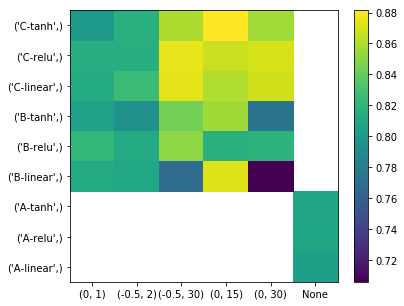

In [86]:
plt.figure(figsize=(6,5))
import matplotlib.pyplot as plt
plt.pcolor(r_test)
plt.yticks(np.arange(0.5, len(r_test.index), 1), r_test.index)
plt.xticks(np.arange(0.5, len(r_test.columns), 1), r_test.columns)
plt.colorbar()
plt.show()

In [78]:
promA=r_test.loc[:,'None'].mean()
promB=r_test.loc[['B-tanh','B-relu','B-linear'],:].mean().mean()
promC=r_test.loc[['C-tanh','C-relu','C-linear'],:].mean().mean()
prom=[promA,promB,promC]
prom
promk1=r_test.loc[:,'(0, 1)'].mean()
promk2=r_test.loc[:,'(-0.5, 2)'].mean()
promk3=r_test.loc[:,'(-0.5, 30)'].mean()
promk4=r_test.loc[:,'(0, 15)'].mean()
promk5=r_test.loc[:,'(0, 30)'].mean()
promk6=promA
promK=[promk1,promk2,promk3,promk4,promk5,promk6]
promK

[0.8115277777777777,
 0.8129166666666666,
 0.8455555555555555,
 0.8593055555555557,
 0.8159722222222222,
 0.8077777777777778]

### Build the bar plots

(0.76, 0.9)

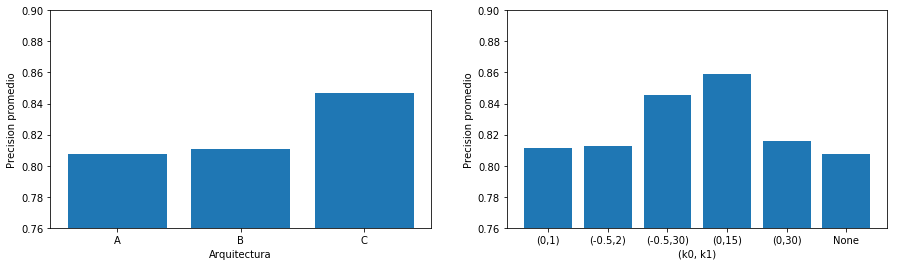

In [93]:
plt.figure(figsize=(15,4))
plt.subplot(121)
x1=['A','B','C']
x2=['(0,1)','(-0.5,2)','(-0.5,30)','(0,15)','(0,30)','None']
plt.bar(x1,prom)
plt.ylabel('Precision promedio')
plt.xlabel('Arquitectura')
plt.ylim(0.76,0.9)
plt.subplot(122)
plt.bar(x2,promK)
plt.ylabel('Precision promedio')
plt.xlabel('(k0, k1)')
plt.ylim(0.76,0.9)
